In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
import pandas as pd

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [3]:
import os

file_path = 'dataset.zip'

if os.path.exists(file_path):
    print(f"File '{file_path}' exists.")
    # You can add further checks here, like trying to open it with a different library
else:
    print(f"File '{file_path}' does not exist.")

File 'dataset.zip' exists.


In [8]:
!pip install python-magic
import magic
print(magic.from_file('dataset.zip'))

Zip archive data, at least v2.0 to extract, compression method=store


In [9]:
import zipfile

print(zipfile.is_zipfile('dataset.zip'))


False


In [12]:
!head dataset.zip

 k��hk��h.
f��eTO�-x	�����n	�����[pw�܃^\�{p��[�.>��ߚ�/�a�۽�V���Z{wu�s���� KAF^  ��� ��π0�������������C�G@�������!"  �"!���#4T��n���=���� l$�`���}@��'����G��,<�?���b����4�?��f����q�8%p�L�]�BS��h>5��]���Q��Ih���xx���>KI����+hhji����[XZY��ڹ{xzy����������MMK�������QRZV^QYU�����j���584<2:6>1����������?8<:>9=�������>>�� ���S�?]�;��t�|��o6<'����+.5W(ާ���dn�k|3�9 �.-�?i��������#e����W����`�‧����hv:��K[Gǒ6�p��E�~ڗ�3/��n"����Y�M�q�#��e�	�;���e*ǞN
����
ފ���[c.��Qވ�V`�nYs��2X�*�
����C��Ǫ�Lj��7*��H���=!�Z���5ח�"�BY��uS����_�ـ{zH�7�|%�u|ʕ�܍s$Uk_$�{s�J�.,�.�����=�|q`�fv`�~��
��k�Ɲ�)�z�����`t��Y_���>�q��}��@Լ�=���SY�����)�u��Ř��@��l�A�Rf$,lp	G�#��;��N̡+rd�5ws��(*���Q�aۤ蛙�B�Q�S{�Ϩ����2��A�q�7��4\�G��B��+��Ư�'?�/	���3��0Ռ(
:{zj�ַ�樐o@�4�N������;�G�p&����s���l�c	�+�/5]���W2d���$�����v�����U,��+����c>E���b,,�m���˒��o&��֓�ϑ`ni�j��[��h�t�����Z���o�hTcO���ßt>�����'p�

In [15]:
import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [16]:
dataset_path = "/content/data/dataset"

In [18]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 15

class_names = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin',
               'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']

print(f"Dataset path: {dataset_path}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {class_names}")

Dataset path: /content/data/dataset
Number of classes: 15
Classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.
Training samples: 1561
Validation samples: 383


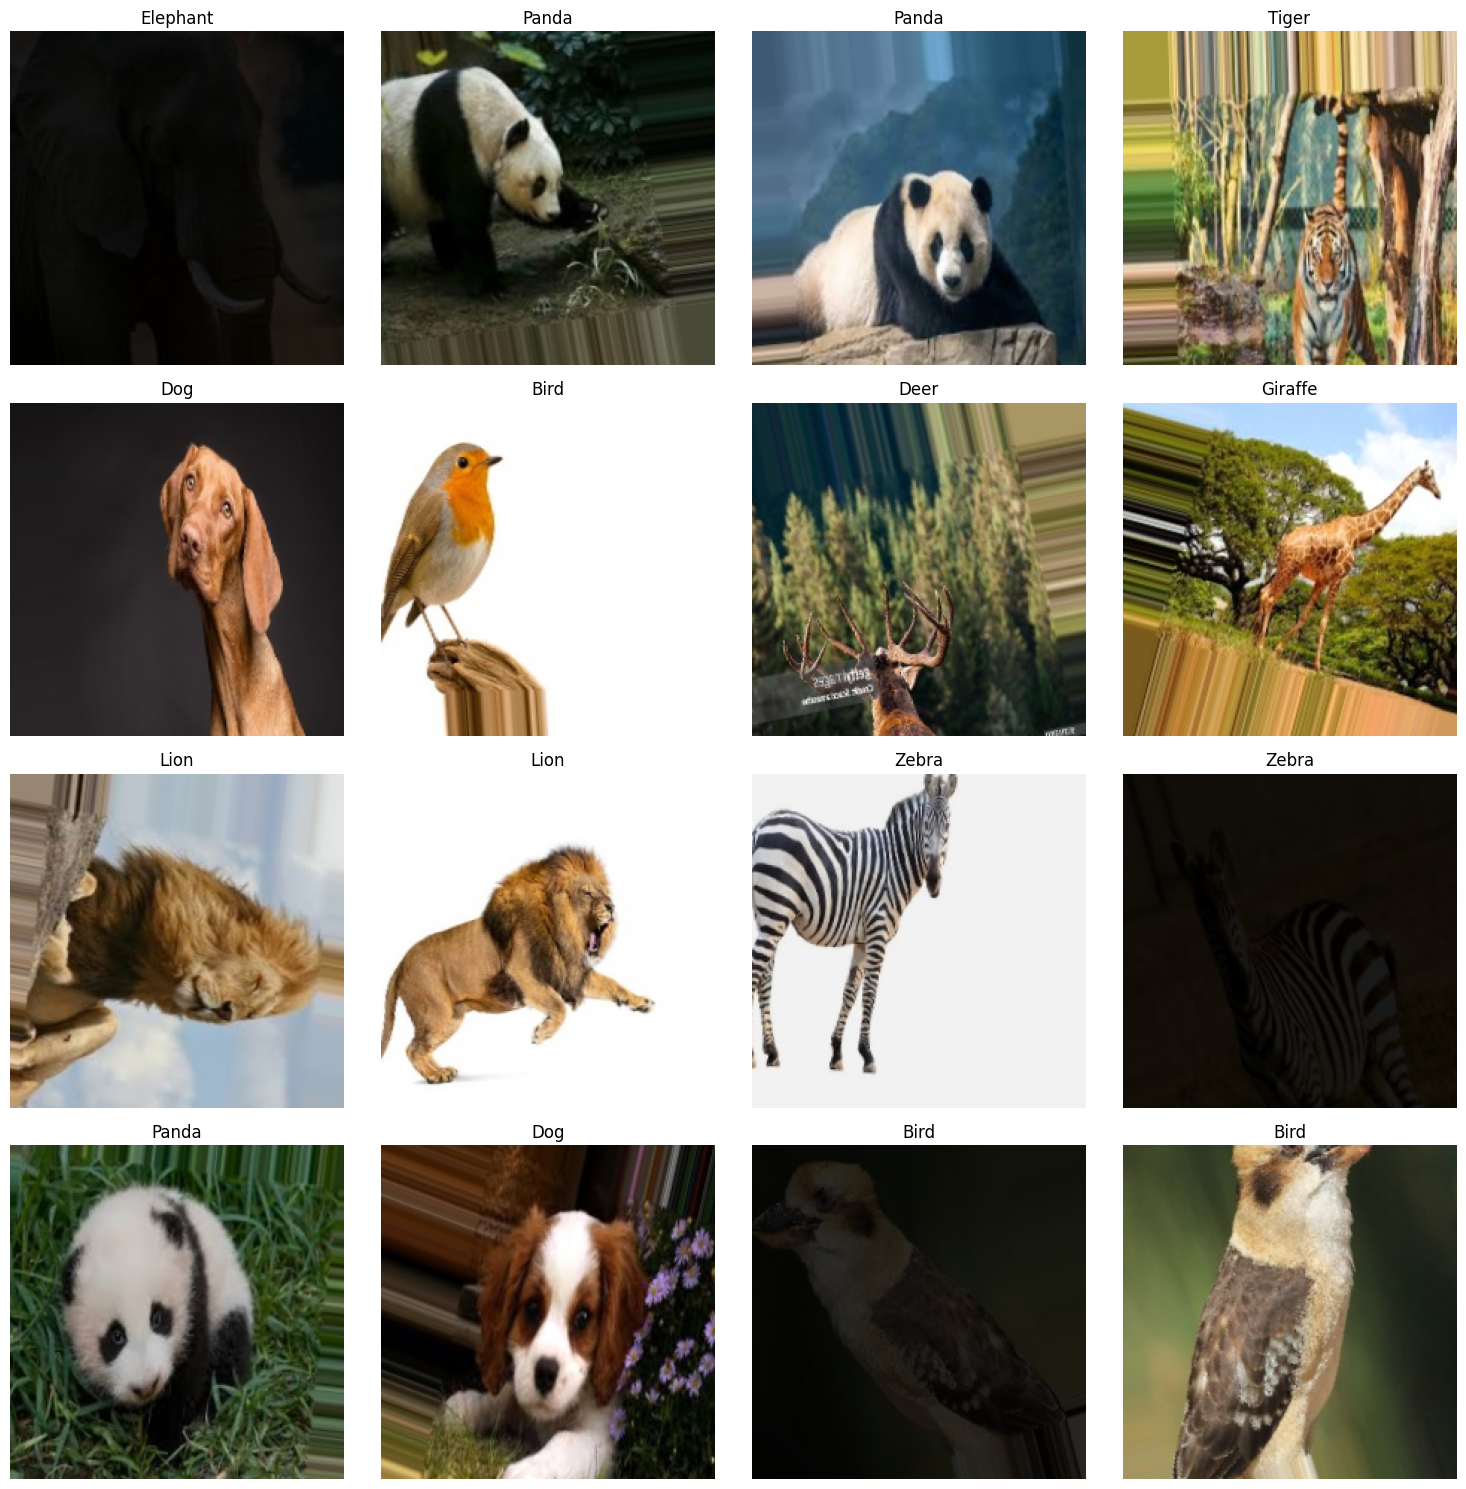

In [20]:
def plot_sample_images(generator, class_names, num_samples=16):
    plt.figure(figsize=(15, 15))

    batch_images, batch_labels = next(generator)

    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i])
        plt.title(class_names[np.argmax(batch_labels[i])])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator, class_names)

In [21]:
#MobileNetV2
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    )
]

In [24]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 748ms/step - accuracy: 0.3204 - loss: 2.2889 - val_accuracy: 0.7702 - val_loss: 0.7940 - learning_rate: 0.0010
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 466ms/step - accuracy: 0.7717 - loss: 0.8022 - val_accuracy: 0.8225 - val_loss: 0.6411 - learning_rate: 0.0010
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.8228 - loss: 0.6114 - val_accuracy: 0.8120 - val_loss: 0.5705 - learning_rate: 0.0010
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - accuracy: 0.8657 - loss: 0.4363 - val_accuracy: 0.8225 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - accuracy: 0.8779 - loss: 0.4007 - val_accuracy: 0.8486 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - accuracy: 0.8764 - loss: 0.3990 - val_accuracy: 0.8225 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 447ms/step - accuracy: 0.9081 - loss: 0.

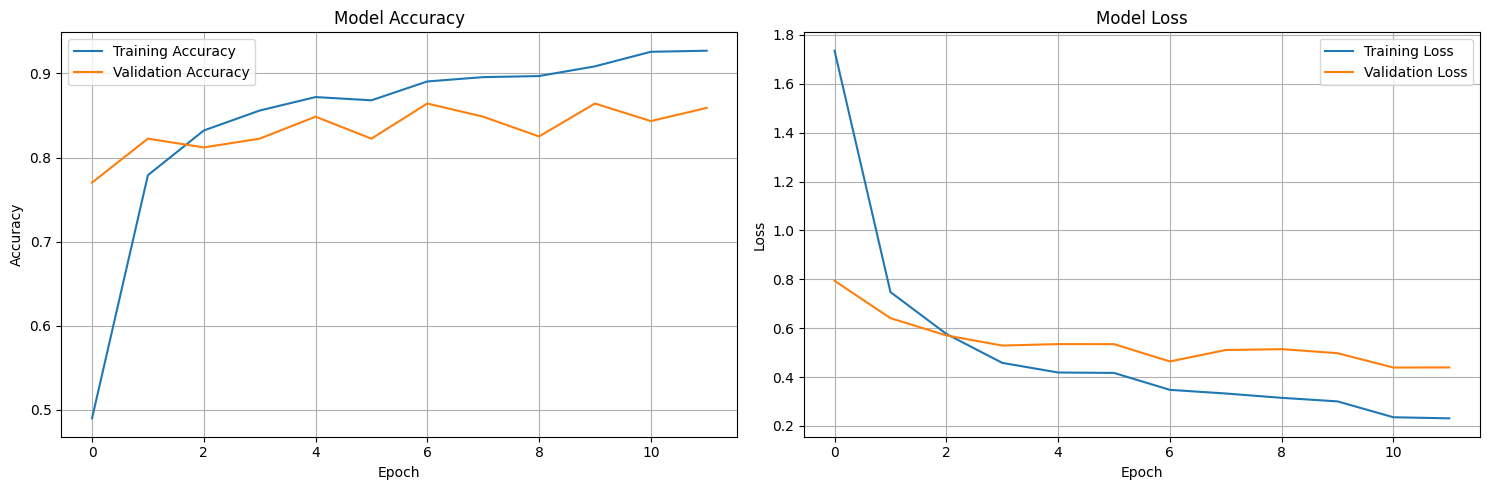

In [25]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [26]:
print("Evaluating model on validation data...")

validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

accuracy = np.mean(predicted_classes == true_classes)
print(f"\nValidation Accuracy: {accuracy:.4f}")

Evaluating model on validation data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 787ms/step

Classification Report:
              precision    recall  f1-score   support

        Bear       0.18      0.12      0.14        25
        Bird       0.09      0.11      0.10        27
         Cat       0.04      0.04      0.04        24
         Cow       0.08      0.08      0.08        26
        Deer       0.00      0.00      0.00        25
         Dog       0.05      0.04      0.04        24
     Dolphin       0.04      0.04      0.04        25
    Elephant       0.03      0.04      0.04        26
     Giraffe       0.04      0.04      0.04        25
       Horse       0.12      0.15      0.14        26
    Kangaroo       0.15      0.12      0.13        25
        Lion       0.00      0.00      0.00        26
       Panda       0.12      0.11      0.11        27
       Tiger       0.08      0.08      0.08        25
       Zebra       0.04      0.04      0.04        27

    accuracy                 

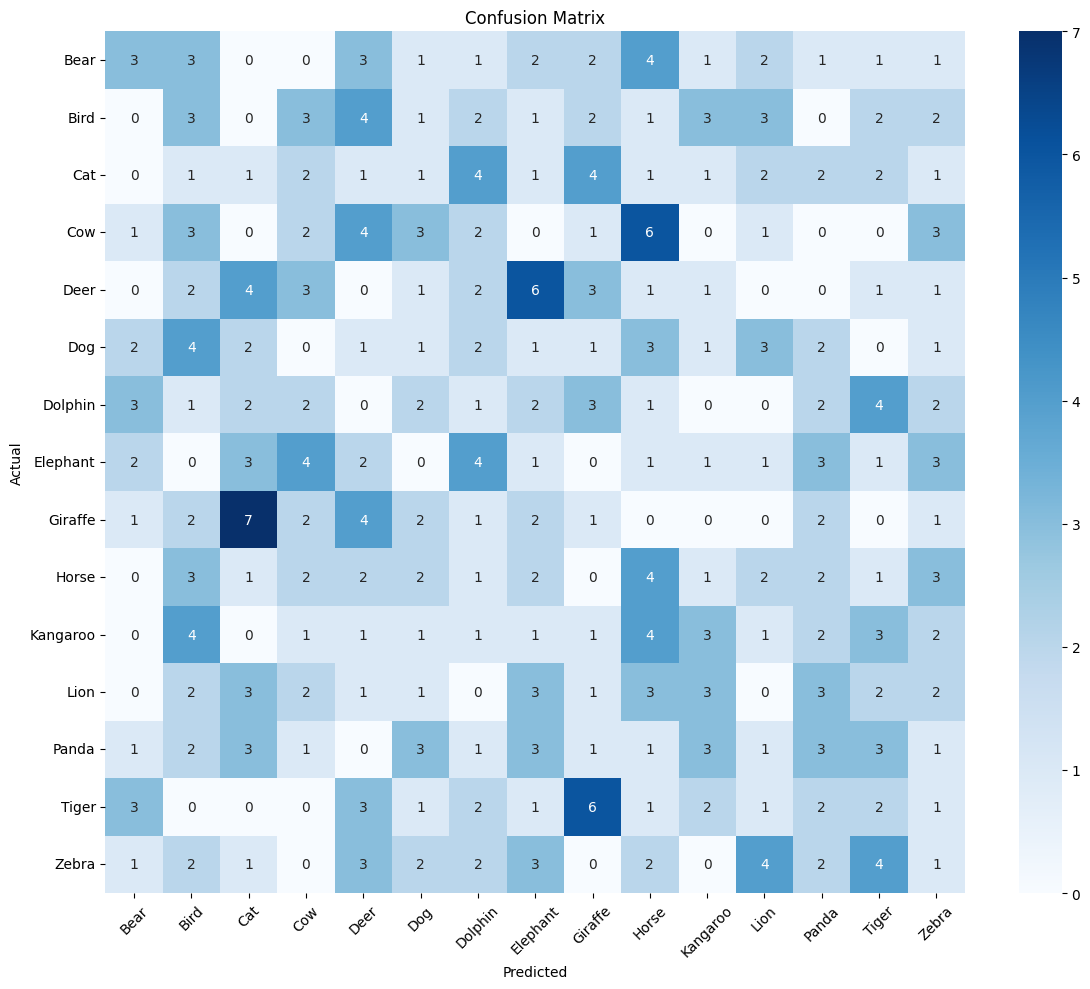

In [27]:
def plot_confusion_matrix(true_classes, predicted_classes, class_names):
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(true_classes, predicted_classes, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Bear
Confidence: 0.9996


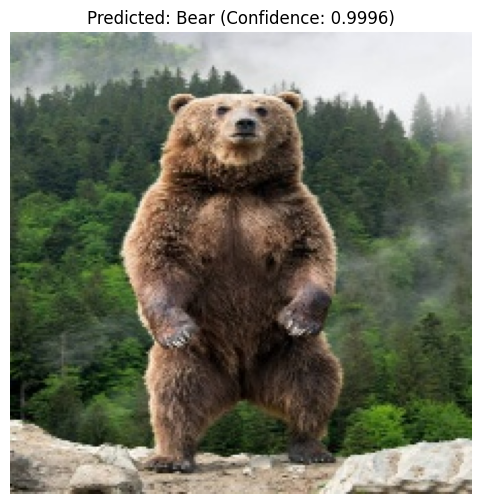

In [28]:

def predict_single_image(image_path, model, class_names):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]

    return class_names[predicted_class_idx], confidence

sample_image_path = r"/content/data/dataset/Bear/Bear_10.jpg"

if os.path.exists(sample_image_path):
    predicted_class, confidence = predict_single_image(sample_image_path, model, class_names)
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")

    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()
else:
    print(f"Sample image not found at: {sample_image_path}")